# Classification for place de marché : TransferLearning using VGG16 model

Now the feasability is established, we will continue to supervised classification

We will : 
- Split our data set
- Augment our data
- Train our model
- Predict our classes

In [44]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.model_selection import StratifiedShuffleSplit

# librairies for NLP
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers,callbacks

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

import cv2

In [27]:
# Using the dataset to prepare the subset "data_img"

data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data['general_category'] = data['product_category_tree'].map(lambda x: x.strip('["]').split(' >> ')[0])
data_img = pd.DataFrame()
data_img['image'] = data['image']
data_img['category'] = data['general_category']
data_img['img_path'] = [os.path.join('data/Images/', filename) for filename in data_img['image']]
data_img.head()

,image,category,img_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,data/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,data/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,data/Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,data/Images/6325b6870c54cd47be6ebfbffa620ec7.jpg


We will split our data in train/test/val directories, and each of them will contain a directory according to the classes to be predicted

In [29]:
#Liste des catégories
categories = data_img["category"].unique().tolist()

#Ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

#Pathing de l'image
image_dir = './data/Images/'

#Dossier de destination
supervised_dir = './data/Images_supervised/'

#Création des dossiers
for category in categories:
    os.makedirs(os.path.join(supervised_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'test', category), exist_ok=True)

#Chemins vers les datasets
train_dir = f'{supervised_dir}train'
validation_dir = f'{supervised_dir}validation'
test_dir = f'{supervised_dir}test'

for category in categories:
    # Filtrer les images de la catégorie en question
    category_images = data_img[data_img['category'] == category]['image'].tolist()

    # Diviser en train, validation, et test
    train_images, test_val_images = train_test_split(category_images, test_size=val_ratio + test_ratio, random_state=22)
    val_images, test_images = train_test_split(test_val_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=22)

    # Déplacer les images vers les répertoires respectifs
    for img in train_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'train', category, img)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'validation', category, img)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'test', category, img)
        shutil.copy(src, dst)

### Création du modèle

Attention !\
keras.Sequential a remplacer avec ImageDataGenerator

In [35]:
model_base=VGG16(include_top=False, weights="imagenet",input_shape=(224, 224, 3))
for layer in model_base.layers:
  layer.trainable = False
#model_base.trainable=False

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.5),
  ])


model = keras.Sequential([
    # Preprocessing
    data_augmentation,
    # Base
    model_base,
    # Head
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #0.001
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build(input_shape=(None,224, 224, 3))
model.summary()

C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [36]:
plot_model(model, show_shapes=True, show_layer_names=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Séparation entre train et test

In [46]:
spliter=StratifiedShuffleSplit(train_size=0.70, n_splits=1,random_state=33)
train_idx =list(spliter.split(data_img['image'], data_img['category']))[0][0]
test_idx=list(spliter.split(data_img['image'], data_img['category']))[0][1]
train_files=data_img.loc[train_idx].reset_index(drop=True)
test_files=data_img.loc[test_idx].reset_index(drop=True)
train_files['category'].value_counts()

category
Kitchen & Dining              105
Baby Care                     105
Beauty and Personal Care      105
Watches                       105
Home Decor & Festive Needs    105
Computers                     105
Home Furnishing               105
Name: count, dtype: int64

CF documentaion on image_dataset_from_directory

In [57]:
X_train = image_dataset_from_directory(
                    directory="data/Images_supervised/train/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    image_size=(224, 224),
                    shuffle=False
                    )

Found 735 files belonging to 7 classes.


In [61]:
X_test = image_dataset_from_directory(
                    directory="data/Images_supervised/test/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    shuffle=False,
                    image_size=(224, 224))

Found 161 files belonging to 7 classes.


In [59]:
X_val = image_dataset_from_directory(
                    directory="data/Images_supervised/validation/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    image_size=(224, 224),
                    shuffle=False
                    )

Found 154 files belonging to 7 classes.


### Fit et prédiction

In [63]:
#define how long to wait before interruption
min_improvement=0.001
epochs_to_wait=10
early_stopping=callbacks.EarlyStopping(monitor='val_loss',
                                       min_delta=min_improvement,
                                       patience=epochs_to_wait,
                                       restore_best_weights=True)

In [64]:
history=model.fit(X_train,validation_data=X_val,epochs=100,verbose=1,callbacks=[early_stopping])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2095 - loss: 14.2977 - val_accuracy: 0.4286 - val_loss: 4.8008
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.1204 - loss: 8.9808 - val_accuracy: 0.7143 - val_loss: 1.4541
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4668 - loss: 2.8215 - val_accuracy: 0.7662 - val_loss: 1.1219
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5175 - loss: 1.9478 - val_accuracy: 0.7792 - val_loss: 0.9787
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5519 - loss: 1.4692 - val_accuracy: 0.7987 - val_loss: 0.8722
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6000 - loss: 1.2658 - val_accuracy: 0.7987 - val_loss: 0.8319
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6755 - loss: 1.0383 - val_accuracy: 0.7922 - val_loss: 0.8285
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6835 - loss: 0.8553 - val_accuracy: 0.7987 - 

It seems that 25 epochs are enough. \
We will limit future testings to 50 epoch max, to ensure no loss, before moving on to optimization \
ATTENTION : early stopped because of a renewal of val_loss ? 

In [65]:
history_frame = pd.DataFrame(history.history)

C:\Users\kanam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kanam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kanam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kanam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

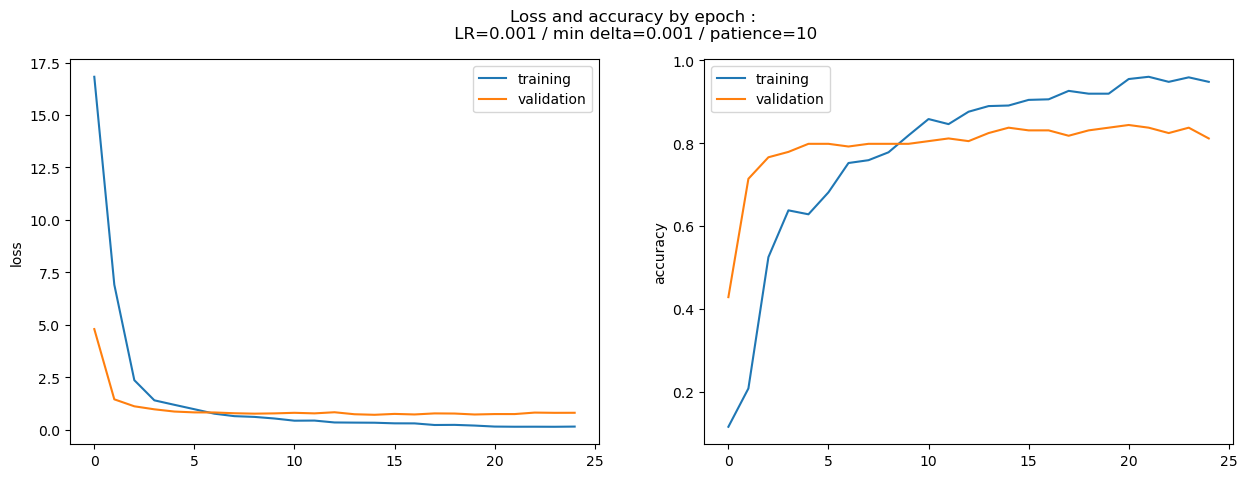

In [66]:
fig,axs=plt.subplots (1,2,figsize=(15,5))
sns.lineplot(history_frame['loss'],label='training',ax=axs[0])
sns.lineplot(history_frame['val_loss'],label='validation',ax=axs[0])

sns.lineplot(history_frame['accuracy'],label='training',ax=axs[1])
sns.lineplot(history_frame['val_accuracy'],label='validation',ax=axs[1])
plt.suptitle('Loss and accuracy by epoch :\n LR='+str(model.optimizer.learning_rate.numpy())+" / min delta="+str(min_improvement)+" / patience="+str(epochs_to_wait))
plt.show()